# YoloV3 TF2 GPU Colab Notebook

##### Clone and install dependencies 

In [ ]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 413 (delta 0), reused 0 (delta 0), pack-reused 410
Receiving objects: 100% (413/413), 4.23 MiB | 40.90 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 394.7MB 44kB/s 
     |████████████████████████████████| 28.7MB 113kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Running setup.py develop for yolov3-tf2


##### Check Tensorflow2 version

In [ ]:
!ls

import tensorflow as tf
tf.__version__

checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


'2.4.0'

get from your gdrive and convert

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
!ls /mydrive/training/backup

yolov3_final.weights  yolov3_last.weights


In [ ]:
# Ubah jadi dataset kalian
!cp /mydrive/training/backup/yolov3_last.weights ./data/yolov3.weights
!cp /mydrive/training/obj.names ./data/coco.names

before run this syntax, edit 'num_class' as total classes of training data

In [ ]:
!python convert.py

2021-05-23 08:50:43.907585: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-23 08:50:45.430444: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-23 08:50:45.431296: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-23 08:50:45.486181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-23 08:50:45.486783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-05-23 08:50:45.486828: I tensorflow/stream_executor/platform/default/dso_loade

##### Initialize Detector

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
# Ubah jadi jumlah kelas kalian
flags.DEFINE_integer('num_classes', 7, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### Detect Image

I0523 09:15:38.477013 140445230520192 <ipython-input-38-30d37e7953b3>:10] weights loaded
I0523 09:15:38.478801 140445230520192 <ipython-input-38-30d37e7953b3>:13] classes loaded
I0523 09:15:38.575083 140445230520192 <ipython-input-38-30d37e7953b3>:24] time: 0.08451151847839355
I0523 09:15:38.576321 140445230520192 <ipython-input-38-30d37e7953b3>:26] detections:


['nasi putih', 'telur rebus']


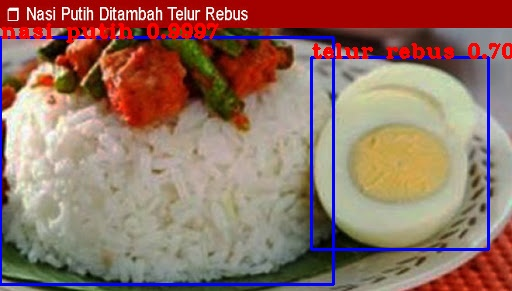

In [ ]:
# Ini kalian ubah gais jadi gambar testing kalian
FLAGS.image = 'data/coba30.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')

nama_kelas = []

for i in range(nums[0]):
    nama_kelas.append(class_names[int(classes[0][i])])
    
    # logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
    #                                     np.array(scores[0][i]),
    #                                     np.array(boxes[0][i])))

print(nama_kelas)

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))